In [1]:
import pandas as pd
import numpy as np
import os
import gc
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
os.chdir('/home/sambeet/data/AV/wns_hackathon/')

In [190]:
train = pd.read_csv('train_LZdllcl.csv')
test = pd.read_csv('test_2umaH9m.csv')

In [172]:
print(train.shape);print(test.shape)
print(train.columns)

(54808, 14)
(23490, 13)
Index([u'employee_id', u'department', u'region', u'education', u'gender',
       u'recruitment_channel', u'no_of_trainings', u'age',
       u'previous_year_rating', u'length_of_service', u'KPIs_met >80%',
       u'awards_won?', u'avg_training_score', u'is_promoted'],
      dtype='object')


In [16]:
print(np.sum(train.isna()))
print(np.sum(test.isna()))
print(train.describe(include='all'))
print(test.describe(include='all'))

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64
employee_id                0
department                 0
region                     0
education               1034
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    1812
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
dtype: int64
         employee_id         department    region   education gender  \
count   54808.000000              54808     54808       52399  54808   
unique           NaN                  9        

In [19]:
x = train.copy()
x.fillna('NA',inplace=True)
x.groupby('previous_year_rating').mean()

,employee_id,no_of_trainings,age,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
previous_year_rating,,,,,,,,
1.0,38786.703841,1.306444,35.335208,6.223686,0.128395,0.017516,60.064760,0.014141
2.0,38993.026272,1.230769,35.182722,6.241893,0.182012,0.017278,61.924024,0.042840
3.0,39292.972876,1.291277,35.582555,6.309324,0.258245,0.021861,64.197819,0.072779
4.0,39346.704667,1.207755,35.281563,6.193986,0.402754,0.022881,64.119773,0.079376
5.0,39148.571587,1.190018,35.535048,6.269142,0.638361,0.030577,63.781364,0.163615
NA,39355.611300,1.310136,26.873424,1.000000,0.349661,0.023278,63.357420,0.082202


In [37]:
z = x.groupby(['department','education'])['employee_id'].agg(['count'])
y = x.groupby(['department'])['employee_id'].agg(['count'])
z = z.join(y,how='left',lsuffix='ab',rsuffix='bc').reset_index()
z['pct'] = 100*z.countab/z.countbc.astype(np.float)
z

,department,education,countab,countbc,pct
0,Analytics,Bachelor's,3978,5352,74.327354
1,Analytics,Master's & above,1037,5352,19.375934
2,Analytics,NA,337,5352,6.296712
3,Finance,Bachelor's,1895,2536,74.723975
4,Finance,Below Secondary,106,2536,4.179811
5,Finance,Master's & above,499,2536,19.676656
6,Finance,NA,36,2536,1.419558
7,HR,Bachelor's,1525,2418,63.068652
8,HR,Below Secondary,128,2418,5.293631
9,HR,Master's & above,733,2418,30.314309


In [38]:
z = x.groupby(['department','previous_year_rating'])['employee_id'].agg(['count'])
y = x.groupby(['department'])['employee_id'].agg(['count'])
z = z.join(y,how='left',lsuffix='ab',rsuffix='bc').reset_index()
z['pct'] = 100*z.countab/z.countbc.astype(np.float)
z

,department,previous_year_rating,countab,countbc,pct
0,Analytics,1,402,5352,7.511211
1,Analytics,2,287,5352,5.362481
2,Analytics,3,1803,5352,33.688341
3,Analytics,4,974,5352,18.198804
4,Analytics,5,1420,5352,26.532138
5,Analytics,NA,466,5352,8.707025
6,Finance,1,170,2536,6.703470
7,Finance,2,124,2536,4.889590
8,Finance,3,916,2536,36.119874
9,Finance,4,481,2536,18.966877


#previous year rating prediction using employees with 2 years of length of service

#dept. wise promotion?
#%new employees, %missing education depts.
#mean encoding
#Stacking/Probability calibration for F1-Score using valid dataset


In [40]:
train.columns

Index([u'employee_id', u'department', u'region', u'education', u'gender',
       u'recruitment_channel', u'no_of_trainings', u'age',
       u'previous_year_rating', u'length_of_service', u'KPIs_met >80%',
       u'awards_won?', u'avg_training_score', u'is_promoted'],
      dtype='object')

In [191]:
train.education.fillna('NA',inplace=True)
train.previous_year_rating.fillna(3.5,inplace=True)
test.education.fillna('NA',inplace=True)
test.previous_year_rating.fillna(3.5,inplace=True)
categorical = ['department','region','education','gender','recruitment_channel']
predictors = list(train.columns.values)
predictors.remove('employee_id')
predictors.remove('is_promoted')
target = 'is_promoted'

In [192]:
for col in categorical:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')
    print 'Transforming {}...'.format(col)
    encoder = LabelEncoder()
    encoder.fit(train[col].append(test[col]).astype(str))
    train[col] = encoder.transform(train[col].astype(str))
    test[col] = encoder.transform(test[col].astype(str))

Transforming department...
Transforming region...
Transforming education...
Transforming gender...
Transforming recruitment_channel...


In [193]:
rounds = 5000
early_stop_rounds = 100
lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric' : 'auc',
    'num_leaves' : 15,
    'max_depth': 6,
    'learning_rate' : 0.01,
    'feature_fraction' : 0.7,
    'verbosity' : 0,
    'num_threads' : 8
}

num_folds = 5
kf = KFold(n_splits=num_folds,shuffle=True,random_state=37)
kf.get_n_splits(train)

5

In [194]:
import collections as cl
results_train = []
results_valid = []
feature_importance = dict()
train['pred_target'] = 0
for i, (train_index, test_index) in zip(range(1,num_folds+1),kf.split(train)):
    X_train = train.loc[train_index,predictors].values
    X_test = train.loc[test_index,predictors].values
    y_train = train.loc[train_index,target].values
    y_test = train.loc[test_index,target].values
    X_train = lgb.Dataset(X_train,y_train,feature_name=predictors,categorical_feature = categorical)
    X_test = lgb.Dataset(X_test,y_test,feature_name=predictors,categorical_feature = categorical)
    gc.collect()
    print 'Starting training on fold:',i
    model = lgb.train(lgbm_params,X_train,num_boost_round=rounds,valid_sets=[X_train,X_test],valid_names=['train','valid'],
                    early_stopping_rounds=early_stop_rounds,verbose_eval=0)
    results_train.append(model.best_score['train']['auc'])
    results_valid.append(model.best_score['valid']['auc'])
    test['target_' + str(i)] = model.predict(test.loc[:,predictors].values)
    train['pred_target'][test_index] = model.predict(train.loc[test_index,predictors].values)
    total_gain = np.sum(model.feature_importance('gain'))
    if i == 1:
        for feature, importance in zip(model.feature_name(),model.feature_importance('gain')):
            feature_importance.update({feature : importance/total_gain})
    else:
        for feature, importance in zip(model.feature_name(),model.feature_importance('gain')):
            feature_importance[feature] = feature_importance[feature] + (importance/total_gain)
for feature,importance in zip(feature_importance.keys(),feature_importance.values()):
    feature_importance[feature] = 100*importance/num_folds
feature_importance = cl.OrderedDict(sorted(feature_importance.items(), key=lambda t: t[1], reverse=True))
print 'Train:' + str(np.mean(results_train)) + '+-' + str(np.std(results_train)), 'Valid:' + str(np.mean(results_valid)) + '+-' + str(np.std(results_valid))

Starting training on fold: 1


/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Starting training on fold: 2
Starting training on fold: 3
Starting training on fold: 4
Starting training on fold: 5
Train:0.9379135334704298+-0.003606224942643283 Valid:0.914135765063145+-0.004969631792033738


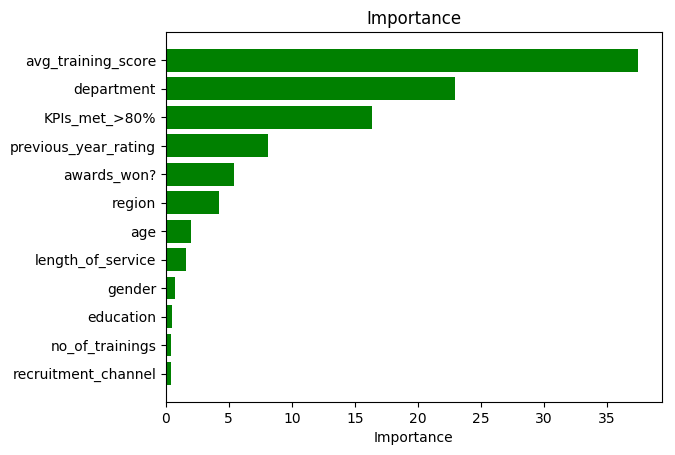

In [177]:
plt.rcdefaults()
fig, ax = plt.subplots()
# Example data
y_pos = np.arange(len(feature_importance.keys()))
ax.barh(y_pos, feature_importance.values(),  align='center',color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(feature_importance.keys())
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Importance')
ax.set_title('Importance')
plt.show()

In [178]:
from sklearn.metrics import f1_score
pred_prob = train.pred_target.values
y_true = train.is_promoted.values
for i in range(0,1001):
    prob_thres = i/1000.
    y_pred = pred_prob >= prob_thres
    print(prob_thres,f1_score(y_true,y_pred))

(0.0, 0.15697087901002085)
(0.001, 0.183249259033898)
(0.002, 0.20457185438446532)
(0.003, 0.22261450381679387)
(0.004, 0.23550788643533122)
(0.005, 0.24738056712379639)
(0.006, 0.2577382268405925)
(0.007, 0.26627827278958194)
(0.008, 0.27306273062730624)
(0.009, 0.2785180758888557)
(0.01, 0.28344588428545353)
(0.011, 0.28739744617852075)
(0.012, 0.2907354226495193)
(0.013, 0.29363177805800755)
(0.014, 0.2957876331266889)
(0.015, 0.29820512820512823)
(0.016, 0.3004652364952184)
(0.017, 0.30251936722869605)
(0.018, 0.30465009510067553)
(0.019, 0.30664552781080723)
(0.02, 0.3084646585544252)
(0.021, 0.3102398554845616)
(0.022, 0.31220333277226053)
(0.023, 0.31371221609179833)
(0.024, 0.31535947712418305)
(0.025, 0.3169788064505084)
(0.026, 0.3181599063425384)
(0.027, 0.31948195858438955)
(0.028, 0.3209163069210416)
(0.029, 0.3225512847441014)
(0.03, 0.32405027637925576)
(0.031, 0.32531484363945096)
(0.032, 0.32685129226065623)
(0.033, 0.32804799657167344)
(0.034, 0.3294895283256098)
(0.0

(0.317, 0.5210205856770078)
(0.318, 0.5214109449847583)
(0.319, 0.5214358378142712)
(0.32, 0.5207909275952312)
(0.321, 0.5209031318281137)
(0.322, 0.5205479452054795)
(0.323, 0.5204200700116687)
(0.324, 0.5204439252336449)
(0.325, 0.5203917555912878)
(0.326, 0.5203394790752122)
(0.327, 0.5194957490472002)
(0.328, 0.5190727699530516)
(0.329, 0.518942731277533)
(0.33, 0.5185947376157578)
(0.331, 0.5189873417721519)
(0.332, 0.5180492117283042)
(0.333, 0.5177754831096032)
(0.334, 0.5176435848220877)
(0.335, 0.5175114526378011)
(0.336, 0.5175983436853002)
(0.337, 0.5176191886289607)
(0.338, 0.5174866627148784)
(0.339, 0.5175074183976262)
(0.34, 0.5175178147268409)
(0.341, 0.5173745173745173)
(0.342, 0.5169441141498217)
(0.343, 0.5168773234200744)
(0.344, 0.5165897931855378)
(0.345, 0.5165227746353082)
(0.346, 0.5164655043957682)
(0.347, 0.5161001788908766)
(0.348, 0.5156763212899372)
(0.349, 0.5156179943207294)
(0.35, 0.5158492822966508)
(0.351, 0.5152603231597845)
(0.352, 0.515337423312883

(0.624, 0.48575567358763877)
(0.625, 0.48575567358763877)
(0.626, 0.4855900821123812)
(0.627, 0.4853462157809984)
(0.628, 0.4851022708970849)
(0.629, 0.484369964550435)
(0.63, 0.48371493066752663)
(0.631, 0.48347040799870994)
(0.632, 0.48347040799870994)
(0.633, 0.4833037586707533)
(0.634, 0.48281426496691954)
(0.635, 0.48256939961265327)
(0.636, 0.48232445520581113)
(0.637, 0.48232445520581113)
(0.638, 0.4824023248304811)
(0.639, 0.4824023248304811)
(0.64, 0.4824023248304811)
(0.641, 0.482157274341999)
(0.642, 0.4819121447028424)
(0.643, 0.48166693587465675)
(0.644, 0.48149943448053)
(0.645, 0.4815772462831286)
(0.646, 0.48133182479392284)
(0.647, 0.48133182479392284)
(0.648, 0.48084074373484237)
(0.649, 0.48084074373484237)
(0.65, 0.47985762821549904)
(0.651, 0.47985762821549904)
(0.652, 0.47985762821549904)
(0.653, 0.4799352750809061)
(0.654, 0.4800129470788153)
(0.655, 0.4800129470788153)
(0.656, 0.4800129470788153)
(0.657, 0.47976691485917766)
(0.658, 0.47976691485917766)
(0.659, 

(0.914, 0.375738616614529)
(0.915, 0.3743259697338667)
(0.916, 0.3723441309648206)
(0.917, 0.370925570855848)
(0.918, 0.36978894121751266)
(0.919, 0.368935427574171)
(0.92, 0.3677960181627663)
(0.921, 0.36694041586580467)
(0.922, 0.365226517404233)
(0.923, 0.3637955182072829)
(0.924, 0.36150070126227213)
(0.925, 0.3600631689770135)
(0.926, 0.35862311204776953)
(0.927, 0.35718052381789417)
(0.928, 0.3566027782662212)
(0.929, 0.3545774647887324)
(0.93, 0.3534178999295279)
(0.931, 0.35283750440606276)
(0.932, 0.35225669957686884)
(0.933, 0.35167548500881834)
(0.934, 0.35051182492057886)
(0.935, 0.3493465206640763)
(0.936, 0.3487632508833922)
(0.937, 0.3475954738330976)
(0.938, 0.34554788458134184)
(0.939, 0.34466879206517886)
(0.94, 0.3417317246273954)
(0.941, 0.34114305999290023)
(0.942, 0.33996447602131435)
(0.943, 0.3384888888888889)
(0.944, 0.337306529087351)
(0.945, 0.3355298308103295)
(0.946, 0.33374933143162777)
(0.947, 0.3332144131287906)
(0.948, 0.3305932809149393)
(0.949, 0.3282

In [179]:
test['is_promoted'] = 0
for i in range(1,num_folds+1):
    test['is_promoted'] = test['is_promoted'] + test['target_'+str(i)]
test['is_promoted'] = test['is_promoted']/float(num_folds)
test['is_promoted'] = (test['is_promoted'] >= 0.28).astype(int)
test[['employee_id','is_promoted']].to_csv('sub_sam_lgb2.csv',index=False)

In [170]:
np.sum(test.is_promoted)/23500.

0.04557446808510638

In [197]:
x = train[train.length_of_service == 2]

In [200]:
x

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,pred_target
4,48945,8,18,0,1,0,1,45,3.0,2,0,0,73,0,0.005268
31,58536,1,24,0,1,0,2,26,1.0,2,0,0,61,0,0.000545
32,35465,7,31,3,0,2,1,24,1.0,2,0,0,48,0,0.000184
41,40097,4,11,0,0,0,2,23,4.0,2,1,0,57,0,0.072577
43,17423,7,11,3,1,0,3,24,2.0,2,0,0,48,0,0.000479
50,24104,1,11,0,1,2,1,20,4.0,2,1,0,60,0,0.027499
55,13596,0,24,0,1,0,2,26,2.0,2,0,0,85,0,0.018194
63,14107,7,0,2,1,2,1,35,4.0,2,1,0,52,0,0.173827
75,54782,7,11,2,1,2,1,38,4.0,2,1,0,49,1,0.184201
78,7520,0,11,0,1,0,1,25,3.0,2,1,0,91,0,0.408636
